In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

plt.style.use("seaborn-v0_8")
random_state = 42

# Unsupervised Learning
- Given a set of variables, the goal is to discover interesting things about them: there is no output variable to predict.


---
---
## Anomaly Detection
- Identification of rare samples which deviate significantly from the majority of the data and/or do not follow a well-defined notion of normal behavior
- In an Unsupervised Approach the samples are not labeled, therefore the goal is to discover dissimilarities among them


---
### &rarr; (Unsupervised) k-Nearest Neighbour
- Given $k$ number of neighbors, $D$ distance threshold. Check every sample $X$ of the dataset. Let $N_X$ be the number of $D$-distance neighbors of $X$. If $N_X < k$ (if a sample has an insufficient number of neighbors) then mark the sample as anomalous, otherwise mark it as normal.

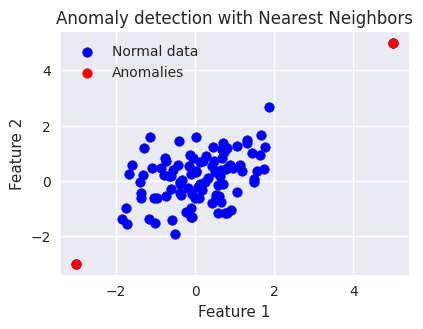

In [10]:
# Generate casual data with two anomalies
np.random.seed(random_state)
normal_data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 100)
data = np.vstack((normal_data, [[5, 5], [-3, -3]]))

model = NearestNeighbors(n_neighbors=5)
model.fit(data)

# Find the nearest neighbors for all points
distances, indices = model.kneighbors(data)

# Identify the indices of anomalies points
anomaly_distance = 2
anomaly_indices = np.where(distances[:, -1] > anomaly_distance)[0]

plt.figure(figsize=(4, 3))
plt.scatter(data[:, 0], data[:, 1], color="blue", label="Normal data")
plt.scatter(
    data[anomaly_indices, 0], data[anomaly_indices, 1], color="red", label="Anomalies"
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Anomaly detection with Nearest Neighbors")
plt.legend()
plt.grid(True)
plt.show()

---
---
## Clustering Methods
-  The goal is to partition the samples of a dataset into distinct groups so that the samples within each group are quite similar to each other, while samples in different groups are quite different from each other.
- In general, clustering is an NP-complete problem, which means that the optimal solution cannot be found without trying all combinations of points and clusters.

### Metrics
| | |
| --- | --- | 
| Rand Index | Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations. <br>Perfect labeling is scored 1.0<br>Poorly agreeing labels (e.g. independent labelings) have lower scores, and for the adjusted Rand index the score will be negative or close to zero. However, for the unadjusted Rand index the score, while lower, will not necessarily be close to zero. | 

---
### &rarr; K-Means
- K-means aims to partition a set of observations into $K$ clusters, where each observation belongs to the cluster with the nearest mean (cluster center or *centroid*). The centroids serve as prototypes for the clusters.
- The number of clusters $K$ must be provided as input.
- K-means tries to minimize the ***Within-Cluster Variation*** or ***Inertia*** or ***Sum-of-squares Criterion*** (squared Euclidean distances), defined as the amount by which the observations belonging to a cluster differ from each other. It's an optimization problem: $$ \min_{C_1, C_2, \ldots, C_K} \left\{\sum_{i=1}^{K} \frac{1}{|C|} \sum_{j,l \in C_i} \sum_{m=1}^p (X_{j,m} - X_{l,m})^2\right\}$$
- Although the problem is NP-hard, efficient heuristic algorithms (such as Lloyd’s or Elkan’s) converge quickly to a local optimum.
- Process:
    - Randomly assign each observation of the dataset to one of the $K$ clusters.
    - At each iteration:
        - Compute the *centroid* of each cluster 
        - Assign each data point to the nearest centroid (typically based on Euclidean distance)
        - Recalculate the centroids by taking the mean of the data points assigned to each cluster.
        - Repeat the iteration until convergence (when centroids no longer change significantly), or until reached a maximum number of iterations or until the total clustering error is below a given threshold
- It is very sensitive to outliers: apply Min-Max Scaling or Standardization to cope with outliers and different value ranges.
- Does not deal with noise and does not deal properly with non convex clusters
- It suffers a lot from high dimensional data
- To choose the correct number of clusters $K$: repeate the computation from $K=1$ until the *Within-Cluster Variation* is pretty constant ("elbow method")
- Run multiple times and choose the solution with minimal *WCV* to cope with the randomness caused by the initial allocation of samples

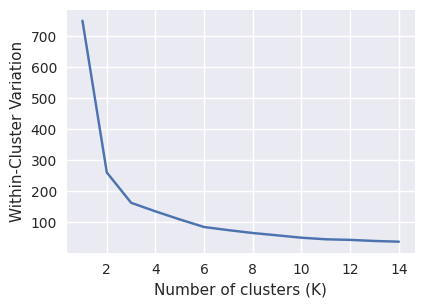

In [11]:
import sklearn
from sklearn import preprocessing


df = pd.read_csv("datasets/iris.data.txt")
df["Class"] = LabelEncoder().fit_transform(df["Class"])
df = preprocessing.StandardScaler().fit_transform(df)


wcv = []
for k in range(1, 15):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=random_state,
    )
    kmeans.fit(df)
    wcv.append(kmeans.inertia_)
plt.figure(figsize=(4, 3))
plt.plot(range(1, 15), wcv)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Within-Cluster Variation")
plt.show()

In [12]:
from kneed import KneeLocator

# Best cluster number
kl = KneeLocator(range(1, 15), wcv, curve="convex", direction="decreasing")
kl.elbow

3

In [15]:
# Model with best number of clusters
from sklearn.metrics import silhouette_score


kmeans = KMeans(
    n_clusters=kl.elbow,
    init="k-means++",
    max_iter=300,
    n_init=10,
    random_state=random_state,
)
kmeans.fit(df)
print(
    f"Sum of squared distances of samples to their centroid: {kmeans.inertia_:.4f}"
)  # same as kmeans.score(X_train)

Sum of squared distances of samples to their centroid: 163.4346


ValueError: x and y must have same first dimension, but have shapes (9,) and (14,)

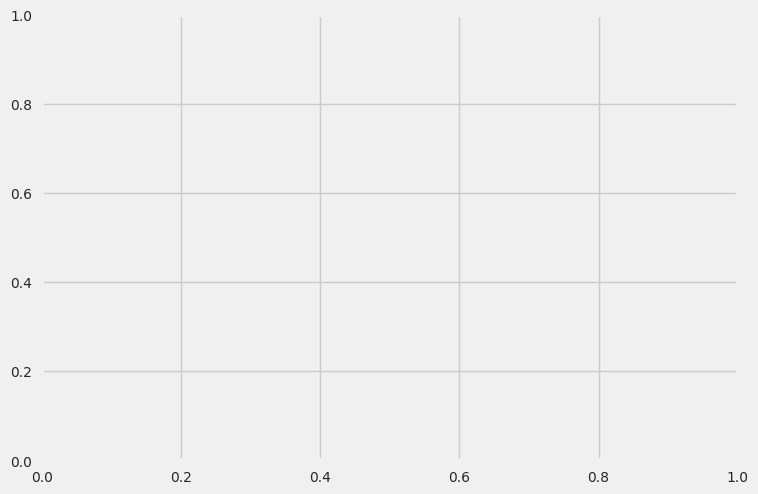

In [16]:
silhouette_coefficients = []
for k in range(1, 15):
    kmeans = KMeans(
        n_clusters=kl.elbow,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=random_state,
    )
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [14]:
# Accuracy cluster function (found online...)
def cluster_acc(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x: -x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate(
        [indexes[0][:, np.newaxis], indexes[1][:, np.newaxis]], axis=-1
    )
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc


y_pred = kmeans.predict(X_test)
print(f"Accuracy: {cluster_acc(y_test, y_pred):.4f}")

NameError: name 'X_test' is not defined

---
### &rarr; Gaussian Mixture Model (GMM)
- It is a probabilistic model that represents a mixture of several Gaussian distributions. It assumes that the data is generated from a combination of multiple Gaussian components. Each component in the mixture corresponds to a cluster within the data.
- The model parameters include:
    - Means (average values) for each Gaussian component.
    - Variances (spread) for each component.
    - Mixing coefficients that determine the contribution of each component to the overall distribution.
- *Expectation-Maximization* (EM) algorithm is commonly used to estimate these parameters from the data:
    - At first it randomly initializes the model parameters
    - At each iteration:
        - Expectation step (E-step): for each observation, find the weights that encode the probability of membership to each cluster (means)
        - Maximization step (M-step): for each cluster, update the model parameters to maximize the likelihood of the observed data (variances and mixing coefficients)
        - Repeat the iteration until the model converges to a local maximum of the likelihood function.

In [ ]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, 0:4]
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

# df = pd.read_csv("datasets/marketing_campaign.csv", sep=";").dropna()
# df_X = pd.get_dummies(df.iloc[:, :-1].drop("Dt_Customer", axis=1))
# df_y = df.iloc[:, -1]

X_train, X_test, _, y_test = train_test_split(
    df_X, df_y, test_size=0.3, random_state=random_state
)

gmm = GaussianMixture(
    n_components=3,
    init_params="k-means++",
    max_iter=300,
    n_init=10,
    random_state=random_state,
).fit(X_train)

y_pred = gmm.predict(X_test)
print(f"Accuracy: {cluster_acc(y_test, y_pred):.4f}")

Accuracy: 0.9778


---
### &rarr; DBSCAN
- Density-Based Spatial Clustering of Applications with Noise
- It doesn't require specifying the $K$ number of clusters beforehand. Instead, it relies on two key parameters: **eps** (maximum distance between data points in the same neighborhood) and **min_samples** (minimum number of data points to form a cluster).
- It identifies clusters based on the density of data points.
-  It assigns one of the following three categories to each sample:
    - Core Points: Data points within a dense region (have at least min_samples neighbors within distance eps).
    - Border Points: Data points on the edge of a cluster (have fewer than min_samples neighbors but are within eps distance from a core point).
    - Noise Points: Isolated data points (not part of any cluster).
- It forms clusters by connecting core points and border points.

In [ ]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, 0:4]
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

# df = pd.read_csv("datasets/marketing_campaign.csv", sep=";").dropna()
# df_X = pd.get_dummies(df.iloc[:, :-1].drop("Dt_Customer", axis=1))
# df_y = df.iloc[:, -1]

clustering = DBSCAN(eps=1, min_samples=4, n_jobs=-1)

y_pred = clustering.fit_predict(df_X)
print(f"Accuracy: {cluster_acc(df_y, y_pred):.4f}")

Accuracy: 0.6667


---
### &rarr; Agglomerative Clustering
- Produce a dendrogram (tree-based representation of the observations). Leafs of the dendrogram are the observations of the dataset. Root of the dendrogram is the parent cluster corresponding to the dataset. One single dendrogram can be used to obtain an arbitrary number of clusters, by simply adding a horizontal cut to the dendrogram.
- Need to give as input a measure of dissimilarity
- Process:
    - Initialize each observation as its own cluster
    - At each iteration:
        - Compute dissimilarity values among all couples of clusters.
        - Merge the two clusters with minimal dissimilarity.
        - Dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion should be placed.
        - Stop iterating when no fusions are possible

Accuracy: 0.8933


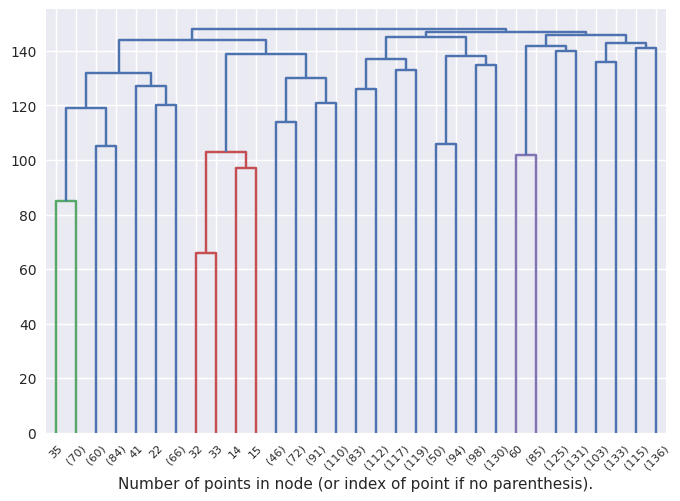

In [ ]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, 0:4]
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

# df = pd.read_csv("datasets/marketing_campaign.csv", sep=";").dropna()
# df_X = pd.get_dummies(df.iloc[:, :-1].drop("Dt_Customer", axis=1))
# df_y = df.iloc[:, -1]

clustering = AgglomerativeClustering(
    n_clusters=3
    # n_clusters=None,
    # distance_threshold=0,
    # compute_full_tree=True,
)
y_pred = clustering.fit_predict(df_X)
print(f"Accuracy: {cluster_acc(df_y, y_pred):.4f}")


# Plotting the dendogram (4 levels)
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0] + 2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )
    dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(clustering, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()